In [1]:
import cobra
from cobra.io import load_json_model, save_json_model
from cobra import Model, Reaction, Metabolite
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
from cobra.manipulation.delete import remove_genes
import seaborn as sns

In [2]:
ipsc = load_json_model('../data/gems/iPSC_gf.json')
icho = load_json_model('../data/gems/iCHOv1.json')
recon1 = load_json_model('../data/gems/RECON1.json')

In [3]:
def add_metabolite(model, template, met_id):
    all_mets = [met.id for met in model.metabolites]
    if met_id not in all_mets:
        temp_met = template.metabolites.get_by_id( met_id )
        model.add_metabolites([Metabolite(id=met_id, formula=temp_met.formula,
                charge=float(temp_met.charge),name=temp_met.name, compartment=temp_met.compartment)])
    return None

def add_rxn(model, template, rxn_id):
    all_rxns = [rxn.id for rxn in model.reactions]
    if  rxn_id not in all_rxns:
        temp_rxn = template.reactions.get_by_id( rxn_id )
        model.add_reactions([Reaction(id=rxn_id,name=temp_rxn.name,subsystem= temp_rxn.subsystem,
                lower_bound=temp_rxn.lower_bound,upper_bound=temp_rxn.upper_bound)])
        for met in (temp_rxn.reactants+temp_rxn.products):
            add_metabolite(model, template, met.id)
        rxn_string = str(temp_rxn.reaction)
        model.reactions.get_by_id(rxn_id).build_reaction_from_string(rxn_string)
        model.reactions.get_by_id(rxn_id).gene_reaction_rule = temp_rxn.gene_reaction_rule
    return None

In [4]:
TCA_rxns =[]; Gly_rxns=[]; PPP_rxns=[]; OXP_rxns=[]; AA_rxns=[];
for rxn in ipsc.reactions:
    if rxn.subsystem == 'Glycolysis/Gluconeogenesis':
        Gly_rxns.append(rxn.id)
    elif rxn.subsystem == 'Citric Acid Cycle':
        TCA_rxns.append(rxn.id)
    elif rxn.subsystem == 'Pentose Phosphate Pathway':
        PPP_rxns.append(rxn.id)
    elif rxn.subsystem == 'Oxidative Phosphorylation':
        OXP_rxns.append(rxn.id)
    elif rxn.subsystem in ['Alanine and Aspartate Metabolism','ALANINE AND ASPARTATE METABOLISM',
                           'Glycine, Serine, and Threonine Metabolism','GLYCINE, SERINE, AND THREONINE METABOLISM',
                           'METHIONINE AND CYSTEINE METABOLISM',
                        'Methionine Metabolism','METHIONINE METABOLISM','Cysteine Metabolism','Glutamate metabolism',
                    'Valine, Leucine, and Isoleucine Metabolism', 'VALINE, LEUCINE, AND ISOLEUCINE METABOLISM',
                'LYSINE METABOLISM', 'Lysine Metabolism', 'PHENYLALANINE METABOLISM','Phenylalanine metabolism',
                'Tyr, Phe, Trp Biosynthesis','Tryptophan metabolism','TRYPTOPHAN METABOLISM','Tyrosine metabolism',
                           'Arginine and Proline Metabolism','Histidine Metabolism']:
        AA_rxns.append(rxn.id)

In [5]:
ipsc_core = Model('iPSC_core')
for rxn_id in (TCA_rxns+Gly_rxns+PPP_rxns):
    add_rxn(ipsc_core, ipsc, rxn_id)
add_rxn(ipsc_core, ipsc, 'ATPM');
# shuttle
add_rxn(ipsc_core, ipsc, 'ASPGLUm'); add_rxn(ipsc_core, ipsc, 'AKGMALtm');add_rxn(ipsc_core, ipsc, 'ASPTAm');
add_rxn(ipsc_core, ipsc, 'GLUDym'); add_rxn(ipsc_core, ipsc, 'MDH');
add_rxn(ipsc_core, ipsc, 'ALATA_L');
# glycogen
add_rxn(ipsc_core, ipsc, 'GALUi'); add_rxn(ipsc_core, ipsc, 'UGLT'); add_rxn(ipsc_core, ipsc, 'UDPG4E');
# Transportation
add_rxn(ipsc_core, ipsc, 'O2tm'); add_rxn(ipsc_core, ipsc, 'PIt2m'); add_rxn(ipsc_core, ipsc, 'Htm'); 
add_rxn(ipsc_core, ipsc, 'ATPtm'); add_rxn(ipsc_core, ipsc, 'PYRt2m'); add_rxn(ipsc_core, ipsc, 'GLCt2'); 
add_rxn(ipsc_core, ipsc, 'GLCt1'); add_rxn(ipsc_core, ipsc, 'L_LACt2r'); add_rxn(ipsc_core, icho, 'PIt'); 
add_rxn(ipsc_core, ipsc, 'O2t'); add_rxn(ipsc_core, ipsc, 'NH4t3r'); add_rxn(ipsc_core, ipsc, 'NH4tm');
add_rxn(ipsc_core, icho, '2AOBUTtm'); add_rxn(ipsc_core, ipsc, 'H2Ot'); add_rxn(ipsc_core, ipsc, 'PYRt2');

In [6]:
# oxidative phosphorylation
OXP_nadh= Reaction(id='OXP_nadh',name='Oxidative Phosphorylation (NADH)',subsystem= 'Oxidative Phosphorylation',
                lower_bound=0.0,upper_bound=1000.0)
OXP_fadh2= Reaction(id='OXP_fadh2',name='Oxidative Phosphorylation (FADH2)',subsystem= 'Oxidative Phosphorylation',
                lower_bound=0.0,upper_bound=1000.0)
ipsc_core.add_reactions([OXP_nadh,OXP_fadh2])
ipsc_core.reactions.OXP_nadh.build_reaction_from_string('nadh_m + 2.5 adp_m + 2.5 pi_m + 3.5 h_m + 0.5 o2_m \
                    --> nad_m + 2.5 atp_m + 3.5 h2o_m')
ipsc_core.reactions.OXP_fadh2.build_reaction_from_string('fadh2_m + 1.5 adp_m + 1.5 pi_m + 1.5 h_m + 0.5 o2_m \
                --> fad_m + 1.5 atp_m + 2.5 h2o_m')

In [7]:
# urea cycle
add_rxn(ipsc_core, ipsc, 'ARGNm'); add_rxn(ipsc_core, ipsc, 'UREAtm'); add_rxn(ipsc_core, ipsc, 'OCBTm');
add_rxn(ipsc_core, ipsc, 'CBPSam'); add_rxn(ipsc_core, ipsc, 'CITRtm');add_rxn(ipsc_core, ipsc, 'ORNt4m');
add_rxn(ipsc_core, ipsc, 'ARGSS'); add_rxn(ipsc_core, ipsc, 'ARGSL'); add_rxn(ipsc_core, ipsc, 'ORNTArm');
add_rxn(ipsc_core, ipsc, 'GLU5SAtmc'); add_rxn(ipsc_core, icho, 'G5SADs'); add_rxn(ipsc_core, ipsc, 'P5CRx');
add_rxn(ipsc_core, ipsc, 'P5CR');

In [8]:
# Nucleotide, NAD+ & NADPH synthesis
NU_rxns = ['GHMT2r','GLUPRT','PRAGSr','GARFT','PRFGS','PRAIS','AIRCr','PRASCSi','ADSL2r','AICART','IMPC',
          'ADSS','ADSL1r','ADK1','IMPD','GMPS2','GK1','CBPS','ASPCT','DHORTS','ORPT','OMPDC','UMPK','UMPK2',
           'NDPK2','NDPK1','NDPK3','NDPK4','NDPK5','NDPK6','NDPK7','NDPK8','TRDR',
           'CTPS1','CTPS2','RNDR1','RNDR2','RNDR3','RNDR4','DCMPDA','TMDS','DHFR','DTMPK','NADK',
          'NNDPR','DNADDP','NADS2','HXPRT','PPA','CYTK2','NDPK1m']
for rxn_id in NU_rxns:
    add_rxn(ipsc_core, ipsc, rxn_id);
ipsc_core.reactions.DNADDP.lower_bound=-1000.0
DHORD_NAD = Reaction(id='DHORD_NAD',name='Dihydoorotic acid dehydrogenase',subsystem='Pyrimidine Biosynthesis',
                lower_bound=0.0,upper_bound=1000.0)
ipsc_core.add_reactions([DHORD_NAD])
ipsc_core.reactions.DHORD_NAD.build_reaction_from_string('dhor__S_c + nad_c --> nadh_c + orot_c')

In [9]:
# Amino acid metabolism
AA_rxns = AA_rxns + ['GLUt2m','FTHFDH','FTHFLi','2AMACHYD','HMGLm','DHPR','IZPN','FTCD','MTHFC']
add_rxn(ipsc_core, icho, 'THRD'); add_rxn(ipsc_core, icho, 'OBDHm'); add_rxn(ipsc_core, icho, 'MMMm');
add_rxn(ipsc_core, icho, 'AM6SAD'); add_rxn(ipsc_core, icho, 'AMCOXO');

for rxn_id in AA_rxns:
    add_rxn(ipsc_core, ipsc, rxn_id);

In [10]:
# Lipid synthesis
lipid_rxns = ['CHOLK','PSSA1','PSFLIPm','PSDm','PE_CHOtm','GPDDA1','MI3PS','MI3PP']
for rxn_id in lipid_rxns:
    add_rxn(ipsc_core, ipsc, rxn_id);
ipsc_core.reactions.GPDDA1.lower_bound=-1000.0

PC_syn = Reaction(id='PC_syn',name='Phosphatidylcholine synthesis',subsystem= 'Glycerophospholipid Metabolism',
                lower_bound=-1000.0,upper_bound=1000.0)
PAIL_syn = Reaction(id='PAIL_syn',name='Phosphatidylinositol synthesis',subsystem= 'Glycerophospholipid Metabolism',
                lower_bound=-1000.0,upper_bound=1000.0)
PG_syn = Reaction(id='PG_syn',name='Phosphatidylglycerol synthesis',subsystem= 'Glycerophospholipid Metabolism',
                lower_bound=-1000.0,upper_bound=1000.0)
SM_syn = Reaction(id='SM_syn',name='Sphingomyelin synthesis',subsystem= 'Glycerophospholipid Metabolism',
                lower_bound=-1000.0,upper_bound=1000.0)
Cholesterol_syn = Reaction(id='Cholesterol_syn',name='Cholesterol synthesis',subsystem= 'Cholesterol Metabolism',
                lower_bound=-1000.0,upper_bound=1000.0)
ipsc_core.add_reactions([PC_syn,PAIL_syn,PG_syn,SM_syn,Cholesterol_syn])
add_metabolite(ipsc_core, ipsc, 'pail_psc_c' ); add_metabolite(ipsc_core, ipsc, 'pglyc_psc_c' );
add_metabolite(ipsc_core, ipsc, 'sphmyln_psc_c'); add_metabolite(ipsc_core, ipsc, 'chsterol_c');
ipsc_core.reactions.PC_syn.build_reaction_from_string('cholp_c + 18 accoa_c + glyc3p_c + 22 atp_c + 33 nadh_c \
                --> pchol_psc_c + 18 coa_c + 16 adp_c + 6 amp_c + 33 nad_c')
ipsc_core.reactions.PAIL_syn.build_reaction_from_string('inost_c + 18 accoa_c + glyc3p_c + 22 atp_c + 33 nadh_c \
            --> pail_psc_c + 18 coa_c + 16 adp_c + 6 amp_c + 33 nad_c')
ipsc_core.reactions.PG_syn.build_reaction_from_string('18 accoa_c + 2 glyc3p_c + 22 atp_c + 33 nadh_c \
                                --> pglyc_psc_c + 18 coa_c + 16 adp_c + 6 amp_c + 33 nad_c')
ipsc_core.reactions.SM_syn.build_reaction_from_string('16 accoa_c + ser__L_c + chol_c + 16 atp_c + 29 nadh_c \
                --> sphmyln_psc_c + 16 coa_c + 2 co2_c + 14 adp_c + 2 amp_c + 29 nad_c')
ipsc_core.reactions.Cholesterol_syn.build_reaction_from_string('18 accoa_c + 18 atp_c + 14 nadph_c \
            --> chsterol_c + 18 coa_c + 9 co2_c + 18 adp_c + 14 nadp_c')

In [11]:
# Nucleotide sugar biosynthesis
nu_sugar_rxns = ['ACOAH','G3PD1ir','BETALDHxm','BETALDHx','SARDHm','MAN6PI','PMANM','MAN1PT2','MAN1PT','GF6PTA',
                'ACGAM6PS','ACGAMPM','UAGDP','UAG2EMA','AMANK','ACNAM9PL','ACNAMPH','ACNMCT','GMAND','UAG4Ei',
                'CACNAO2','CACNAO']
for rxn_id in nu_sugar_rxns:
    add_rxn(ipsc_core, ipsc, rxn_id);

In [12]:
# Transporters and exchange rxns
add_rxn(ipsc_core, icho, 'r1437'); add_rxn(ipsc_core, icho, 'r1078'); add_rxn(ipsc_core, icho, 'LEUt5m');
add_rxn(ipsc_core, icho, 'r1435'); add_rxn(ipsc_core, icho, 'thr_mt'); add_rxn(ipsc_core, icho, 'thr_mt');
add_rxn(ipsc_core, icho, 'PHEt2m'); add_rxn(ipsc_core, icho, 'VALt5m');
tp_rxns = ['CHOLtu','CHLtm','HCO3Em','HCO3_NAt','H2Otm','CO2tm','CO2t','NAt','ACt2m','ACt2r','HYXNt','SO4t4_2',
           'ASNtm','ASNt4','CYStec','GLNtm','GLNt4','LYStm','LYSt4','PROtm','PROt2r','TYRt',
          'METt4','LEUt4','SERt4','HISt4','THRt4','PHEt4','ARGt4','ARGtm','ILEtmi','ILEt4',
           'VALt4','TRPt','ASPt6','ALAtmi','ALAt2r','GLUt6','GLYtm','GLYt4',
          'FUMtm','SUCCtm','MALtm','UREAtm','UREAt','COAtim',
           'PIt9','PPItm']
for rxn_id in tp_rxns:
    add_rxn(ipsc_core, ipsc, rxn_id);
ACCOAt2m = Reaction(id='ACCOAt2m',name='ACCOAt2m',subsystem= 'TRANSPORT, MITOCHONDRIAL',
                lower_bound=-1000.0,upper_bound=1000.0)
ipsc_core.add_reactions([ACCOAt2m])
ipsc_core.reactions.ACCOAt2m.build_reaction_from_string('accoa_m <=> accoa_c')
# Add boundary reactions
for  met in ipsc_core.metabolites.query('_e'):
    if met.compartment == 'e':
        add_rxn(ipsc_core, ipsc, 'EX_'+met.id);

In [13]:
# Define growth function
BIOMASS = Reaction(id='BIOMASS',name='BIOMASS_psc_core',subsystem='Biomass and maintenance functions',
               lower_bound=0.0,upper_bound=1000.0)
rxn_string ='0.449091248 ala__L_c + 0.24692711 arg__L_c + 0.208891647 asn__L_c + 0.257573151 asp__L_c + 29.93484474 atp_c \
            + 0.086970857 chsterol_c + 0.097355132 ctp_c + 0.083083581 cys__L_c + 0.035778189 datp_c + 0.025172729 dctp_c \
            + 0.025172729 dgtp_c + 0.035778189 dttp_c + 0.353206758 gln__L_c + 0.303246063 glu__L_c + 0.476689682 gly_c + \
            0.102935005 gtp_c + 24.74849172 h2o_c + 0.096216462 his__L_c + 0.220171565 ile__L_c + 0.427292446 leu__L_c \
            + 0.387642487 lys__L_c + 0.105583014 met__L_c + 0.018176901 pail_psc_c + 0.130185913 pchol_psc_c +\
            0.049863661 pe_psc_c + 0.001473803 pglyc_psc_c + 0.186720668 phe__L_c + 0.222059892 pro__L_c + 0.016457464 ps_psc_c \
            + 0.32299952 ser__L_c + 0.02137014 sphmyln_psc_c + 0.255370881 thr__L_c + 0.025172972 trp__L_c \
            + 0.131253338 tyr__L_c + 0.085375963 utp_c + 0.32262571 val__L_c \
            --> 29.83030991 adp_c + 29.83030991 h_c + 29.83030991 pi_c + 0.512102766 ppi_c'
ipsc_core.add_reactions([BIOMASS])
ipsc_core.reactions.BIOMASS.build_reaction_from_string(rxn_string)
ipsc_core.objective = {ipsc_core.reactions.BIOMASS: 1}

In [14]:
ipsc_core.remove_metabolites(ipsc_core.metabolites.query('CE')+ipsc_core.metabolites.query('r1p'), destructive=True)
ipsc_core.remove_metabolites(ipsc_core.metabolites.query('_x')+ipsc_core.metabolites.query('_n')+\
                            ipsc_core.metabolites.query('_r') , destructive=True)
mets_remove = ['56dihindlcrbxlt_c','melanin_c','n4abutn_c','aprut_c','2c23dh56dhoxin_c','pcollglys_c','pcollg5hlys_c',
              'homoval_c','42A3HP24DB_c','Nacasp_c','HC00591_c','HC00250_c','C08276_c','pcollg5glys_c',
              'Nacasp_m','HC00900_m','srtn_c','ptrc_c','ptrc_m','sl__L_c','sl__L_m']
for met_id in mets_remove:
    ipsc_core.remove_metabolites( ipsc_core.metabolites.get_by_id(met_id), destructive=True)

In [15]:
for rxn in ipsc_core.reactions:
    rxn.subsystem = str.title(rxn.subsystem)

# Rxn directions

In [16]:
TKT1_rev = Reaction(id='TKT1_rev',name='TKT1_rev',subsystem='Pentose Phosphate Pathway',lower_bound=0.0,upper_bound=1000.0)
TKT2_rev = Reaction(id='TKT2_rev',name='TKT2_rev',subsystem='Pentose Phosphate Pathway',lower_bound=0.0,upper_bound=1000.0)
TALA_rev = Reaction(id='TALA_rev',name='TALA_rev',subsystem='Pentose Phosphate Pathway',lower_bound=0.0,upper_bound=1000.0)
RPI_rev = Reaction(id='RPI_rev',name='RPI_rev',subsystem='Pentose Phosphate Pathway',lower_bound=0.0,upper_bound=1000.0)
RPE_rev = Reaction(id='RPE_rev',name='RPE_rev',subsystem='Pentose Phosphate Pathway',lower_bound=0.0,upper_bound=1000.0)
ipsc_core.add_reactions([TKT1_rev,TKT2_rev,TALA_rev,RPI_rev,RPE_rev])
ipsc_core.reactions.TKT1.build_reaction_from_string('r5p_c + xu5p__D_c --> g3p_c + s7p_c')
ipsc_core.reactions.TKT2.build_reaction_from_string('e4p_c + xu5p__D_c --> f6p_c + g3p_c')
ipsc_core.reactions.TALA.build_reaction_from_string('g3p_c + s7p_c --> e4p_c + f6p_c')
ipsc_core.reactions.RPI.build_reaction_from_string('r5p_c --> ru5p__D_c')
ipsc_core.reactions.RPE.build_reaction_from_string('ru5p__D_c --> xu5p__D_c')
ipsc_core.reactions.TKT1_rev.build_reaction_from_string('g3p_c + s7p_c --> r5p_c + xu5p__D_c')
ipsc_core.reactions.TKT2_rev.build_reaction_from_string('f6p_c + g3p_c --> e4p_c + xu5p__D_c')
ipsc_core.reactions.TALA_rev.build_reaction_from_string('e4p_c + f6p_c --> g3p_c + s7p_c')
ipsc_core.reactions.RPI_rev.build_reaction_from_string('ru5p__D_c --> r5p_c')
ipsc_core.reactions.RPE_rev.build_reaction_from_string('xu5p__D_c --> ru5p__D_c')

In [18]:
ipsc_core.reactions.GDHm.build_reaction_from_string('akg_m + h_m + nadh_m + nh4_m --> glu__L_m + h2o_m + nad_m')
ipsc_core.reactions.ACOAH.build_reaction_from_string('accoa_c + h2o_c --> ac_c + coa_c + h_c')
ipsc_core.reactions.AATA.build_reaction_from_string('L2aadp_c + akg_c --> 2oxoadp_c + glu__L_c')
ipsc_core.reactions.ECOAH1m.build_reaction_from_string('b2coa_m + h2o_m --> 3hbcoa_m')
ipsc_core.reactions.HACD1m.build_reaction_from_string('3hbcoa_m + nad_m --> aacoa_m + h_m + nadh_m')
ipsc_core.reactions.ACACT1m.build_reaction_from_string('aacoa_m + coa_m --> 2.0 accoa_m')
ipsc_core.reactions.VALTAim.build_reaction_from_string('akg_m + val__L_m --> 3mob_m + glu__L_m')
ipsc_core.reactions.MMEm.build_reaction_from_string('mmcoa__S_m --> mmcoa__R_m')
ipsc_core.reactions.MMMm.build_reaction_from_string('mmcoa__R_m --> succoa_m')
ipsc_core.reactions.SUCOASm.build_reaction_from_string('adp_m + pi_m + succoa_m --> atp_m + coa_m + succ_m')
ipsc_core.reactions.GLYCLm.build_reaction_from_string('gly_m + nad_m + thf_m --> co2_m + mlthf_m + nadh_m + nh4_m')
ipsc_core.reactions.ASPCT.build_reaction_from_string('asp__L_c + cbp_c --> cbasp_c + h_c + pi_c')
ipsc_core.reactions.DHORTS.build_reaction_from_string('cbasp_c + h_c --> dhor__S_c + h2o_c')
ipsc_core.reactions.DHORD_NAD.build_reaction_from_string('dhor__S_c + nad_c --> nadh_c + orot_c')
ipsc_core.reactions.ORPT.build_reaction_from_string('orot_c + prpp_c --> orot5p_c + ppi_c')
ipsc_core.reactions.MDH.build_reaction_from_string('h_c + nadh_c + oaa_c --> mal__L_c + nad_c')
ipsc_core.reactions.FUMm.build_reaction_from_string('fum_m + h2o_m --> mal__L_m')
ipsc_core.reactions.FUM.build_reaction_from_string('fum_c + h2o_c --> mal__L_c')
ipsc_core.reactions.AKGMALtm.build_reaction_from_string('akg_c + mal__L_m --> akg_m + mal__L_c')
ipsc_core.reactions.GLYATm.build_reaction_from_string('accoa_m + gly_m --> 2aobut_m + coa_m')

# Correct GPRs

In [19]:
correct_gprs = pd.read_csv('../data/gems/correct_gprs.csv')

In [20]:
for i in range(len(correct_gprs.index)):
    rxn_id = list(correct_gprs.rxn_id)[i]
    temp_gpr = list(correct_gprs.gpr)[i]
    if temp_gpr == '_':
        temp_gpr=''
    ipsc_core.reactions.get_by_id(rxn_id).gene_reaction_rule = temp_gpr

In [21]:
remove_list = [];
for gene in ipsc_core.genes:
    if len(gene.reactions) == 0:
        remove_list.append(gene.id)
remove_genes(ipsc_core, remove_list)  

In [22]:
medium = ipsc_core.medium
medium['EX_ala__L_e']=1000.0
medium['EX_gly_e']=1000.0
medium['EX_glu__L_e']=1000.0
medium['EX_na1_e']=1000.0
medium['EX_k_e']=1000.0
ipsc_core.medium = medium 

In [23]:
# save_json_model(ipsc_core,'../data/gems/iPSC_core.json')

In [ ]:
# gap_biomass = []
# for met in ipsc_core.reactions.BIOMASS_psc_core.reactants:
#     with ipsc_core:
#         ipsc_core.objective = ipsc_core.add_boundary(met, type='demand')
#         if ipsc_core.slim_optimize() <= 0:
#             gap_biomass.append(met.id)

In [3]:
ipsc_core = load_json_model('../data/gems/iPSC_core.json')
ipsc_core

Name,iPSC_core
Memory address,0x07f5224319e50
Number of metabolites,495
Number of reactions,504
Number of groups,0
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"c, m, e"


In [4]:
# fluxes = ipsc_core.optimize().fluxes

In [5]:
# fluxes.to_csv('../data/gems/fluxes_nocon.csv')

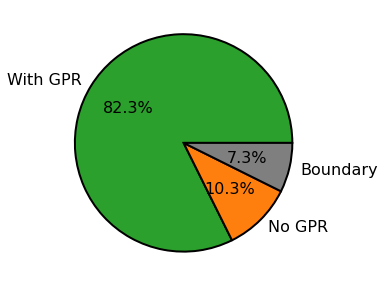

In [6]:
gpr_status={'With GPR':0,'No GPR':0,'Boundary':len(ipsc_core.boundary)}
for rxn in ipsc_core.reactions-ipsc_core.boundary:
    if rxn.gene_reaction_rule == '':
        gpr_status['No GPR'] +=1
    else:
        gpr_status['With GPR'] +=1
        
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pie(gpr_status.values(), labels=gpr_status.keys(),autopct='%1.1f%%',
           wedgeprops = {"edgecolor" : "black",'linewidth': 2,'antialiased': True},textprops={'fontsize': 16},
      colors=['tab:green','tab:Orange','tab:grey']);

Text(0.5, 1.0, 'Subsystems of curated reactions')

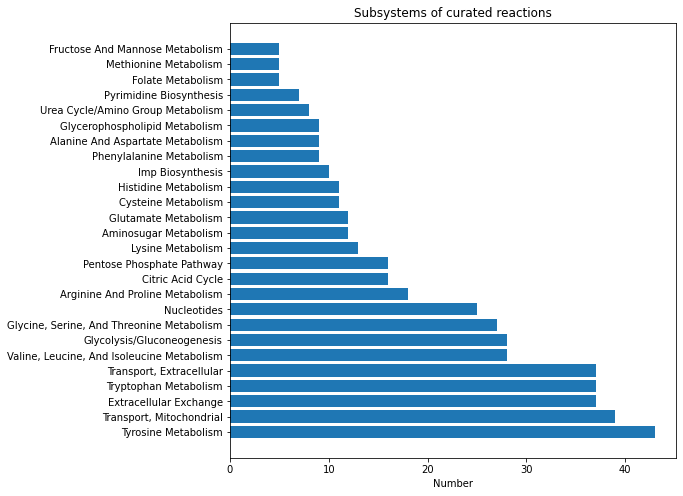

In [8]:
subsystems={}
for rxn in ipsc_core.reactions:
    if rxn.subsystem not in subsystems:
        subsystems[rxn.subsystem] = 1
    else:
        subsystems[rxn.subsystem] += 1
subsystem_pd = pd.DataFrame(subsystems.items(),columns=['Subsystem','Count'])
subsystem_pd = subsystem_pd.sort_values(by=['Count'],ascending=False).reset_index().drop(['index'],axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,8))
temp_pd = subsystem_pd[subsystem_pd['Count']>=5]
ax.barh(list(temp_pd['Subsystem']),list(temp_pd['Count']) )
ax.set_xlabel('Number')
ax.set_title('Subsystems of curated reactions')

In [ ]:
# recon1_genes = [gene.id for gene in recon1.genes]
# icho_genes = [gene.id for gene in icho.genes]

In [ ]:
# wrong_rxn=[];
# for rxn in ipsc_core.reactions-ipsc_core.boundary:
#     if len(rxn.genes)<1:
#         continue
#     for gene in rxn.genes:
#         if (gene.id in recon1_genes) or (gene.id in icho_genes):
#             wrong_rxn.append(rxn.id)
#             continue
# wrong_rxn = list(np.unique(wrong_rxn)); wrong_gprs=[]
# for rxn_id in wrong_rxn:
#     wrong_gprs.append(ipsc_core.reactions.get_by_id(rxn_id).gene_reaction_rule)

# correct_gpr_pd = pd.DataFrame(zip(wrong_rxn,wrong_gprs),columns=['rxn_id','wrong gpr'])
# correct_gpr_pd.to_csv('../data/gems/correct_gprs.csv',index=None)

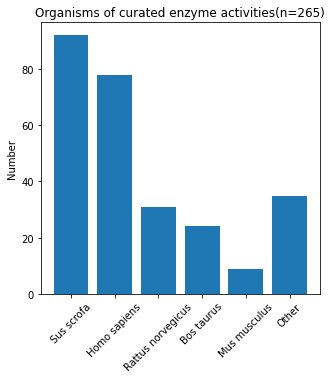

In [14]:
Adata = pd.read_csv('../data/gems/EnzymeActivity.csv')
org_stats={}
for org in list(Adata['Organism']):
    org = org.strip()
    if org not in org_stats:
        org_stats[org]=1
    else:
        org_stats[org] +=1
org_pd = pd.DataFrame(org_stats.items(),columns=['Organism','Count']).sort_values(by=['Count'],ascending=False).\
                        reset_index().drop(['index'],axis=1)
fig, ax = plt.subplots(1,1,figsize=(5,5))
temp_pd = org_pd[org_pd['Count']>7]
ax.bar(list(temp_pd['Organism'])+['Other'],list(temp_pd['Count'])+[sum(org_pd['Count'])-sum(temp_pd['Count'])] )
ax.set_ylabel('Number')
ax.set_title('Organisms of curated enzyme activities(n=265)')
plt.xticks(rotation=45);

In [31]:
subsys = []
for i in range(len(Adata.index)):
    if 'EX' in list(Adata.Rxn)[i] or list(Adata.Rxn)[i] in ['BIOMASS','ATPM']:
        subsys.append('None')
    else:
        subsys.append( ipsc_core.reactions.get_by_id(list(Adata.Rxn)[i]).subsystem )
Adata['Subsystem']=subsys
Adata = Adata[Adata.Subsystem.isin(['Glycolysis/Gluconeogenesis','Pentose Phosphate Pathway','Citric Acid Cycle',
                        'Alanine And Aspartate Metabolism', 'Aminosugar Metabolism','Arginine And Proline Metabolism',
                    'Cysteine Metabolism','Glutamate Metabolism','Glycine, Serine, Alanine And Threonine Metabolism',
                      'Histidine Metabolism', 'Imp Biosynthesis', 'Inositol Phosphate Metabolism','Folate Metabolism',
                    'Lysine Metabolism', 'Methionine Metabolism', 'Nad Metabolism', 'Nucleotide Interconversion', 
                            'Nucleotides','Phenylalanine Metabolism', 'Pyrimidine Biosynthesis','Tryptophan Metabolism',
                    'Tyrosine Metabolism','Urea Cycle/Amino Group Metabolism','Valine, Leucine, And Isoleucine Metabolism'])]

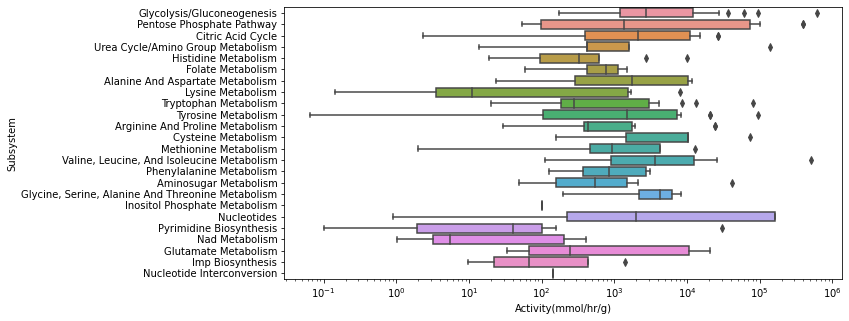

In [39]:
fig, ax=plt.subplots(1,1,figsize=(10,5))
sns.boxplot(data=Adata,y='Subsystem',x='Activity(mmol/hr/g)')
ax.set_xscale('log')

In [ ]:
# ir_rxns=[]; compartments=[]
# for rxn in ipsc_core.reactions:
#     if (rxn.id not in list(Adata['Rxn'])) and (rxn.reversibility==0) \
#         and ('EX_' not in rxn.id) and ('_syn' not in rxn.id) \
#     and (rxn.subsystem not in ['TRANSPORT, MITOCHONDRIAL','Transport, Extracellular']):
#         ir_rxns.append(rxn.id)
# for rxn_id in ir_rxns:
#     if rxn_id[-1]=='m':
#         compartments.append('m')
#     else:
#         compartments.append('c')

In [ ]:
# irrxn_pd = pd.DataFrame(zip(ir_rxns,compartments),columns=['Rxn','Compartment'])
# irrxn_pd = irrxn_pd.sort_values(by=['Compartment']).reset_index().drop(['index'],axis=1)
# irrxn_pd.to_csv('../data/gems/irrxn_Activity.csv',index=None)

In [18]:
with ipsc_core:
    ipsc_core.medium={'EX_glc__D_e': 0.0,'EX_h_e': 1000.0,'EX_pi_e': 1000.0,'EX_o2_e': 1000.0,
 'EX_h2o_e': 1000.0,'EX_chol_e': 1000.0,'EX_hco3_e': 1000.0,'EX_na1_e': 1000.0,'EX_hxan_e': 1000.0,
 'EX_so4_e': 1000.0,'EX_asn__L_e': 0.0,'EX_cys__L_e': 0.0,'EX_gln__L_e': 1.0,'EX_lys__L_e': 0.0,
'EX_pro__L_e': 0.0,'EX_tyr__L_e': 0.0,'EX_met__L_e': 0.0,'EX_leu__L_e': 0.0,'EX_ser__L_e': 0.0,
 'EX_his__L_e': 0.0,'EX_thr__L_e': 0.0,'EX_phe__L_e': 0.0,'EX_arg__L_e': 0.0,'EX_ile__L_e': 0.0,
 'EX_val__L_e': 0.0,'EX_trp__L_e': 0.0,'EX_asp__L_e': 0.0,'EX_k_e': 1000.0,'EX_ala__L_e': 0.0,
 'EX_glu__L_e': 0.0,'EX_gly_e': 0.0}
    ipsc_core.objective = ipsc_core.reactions.ATPM
    fluxes=ipsc_core.optimize().fluxes
    print(fluxes['SUCD1m'])
    print(fluxes['OXP_nadh'])

1.0
2.0


In [9]:
#icho fluxes
# fluxes = icho.optimize().fluxes
# fluxes.to_csv('../data/gems/fluxes_icho.csv')